In [16]:
import sys, os
BIN = os.path.expanduser("../../../")
sys.path.append(BIN)

In [17]:
import numpy as np
from scipy.constants import m_p, c, e
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math as m

from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.trackers.simple_long_tracking import LinearMap
import PyHEADTAIL.particles.generators as generators
import PyHEADTAIL.cobra_functions.stats as st


In [18]:

def plot_params_vs_gamma(ax=[-1.4,-1], ay=[-1.1, 1.1], bx=[35, 81], by=[4, 51], dx=[5, 20], dy=[-4, 1000], N=50000):
    # global parameters
    nsamples = 10
    Q_x = 20.13
    Q_y = 20.18
    Q_s = 0.017
    epsx = [3.75e-6, 3.75e-6]
    epsy = [3.75e-6, 3.75e-6]
    gx = (1. + np.array(ax)*np.array(ax))/np.array(bx)
    C = 6911.
    R = C / (2.*np.pi)

    alpha_0 = [0.00308]    
        
    
        
    def _run_for_range(gammas):
        """ Run the test for the specified gamma range"""
        
        def _plot_error(values_dp, values_dE, gammas, title='param', logscale=False, param=ax):
            """ Plot the computed values usiing dp, dE in a nice way"""
            ax1, = plt.plot(gammas, values_dp[:,0], label='dp, ' + str(param[0]))
            ax2, = plt.plot(gammas, values_dp[:,1], label='dp, ' + str(param[1]))
            #print(values_dp[:,1])
            ax3, = plt.plot(gammas, values_dE[:,0], label='dE, ' + str(param[0]))
            ax4, = plt.plot(gammas, values_dE[:,1], label='dE, ' + str(param[1]))

            plt.xlabel('gamma')
            plt.ylabel('relative <L1 error> of ' + str(nsamples) + ' samples, N=' + str(N))
            plt.title(title)
            plt.legend(handles=[ax1, ax3, ax2, ax4])
            if logscale:
                plt.yscale('log')
            plt.show()
        
        
        ax_L1 = np.zeros(shape=(len(gammas),2))
        ax_L1_dE = np.zeros(shape=(len(gammas),2))
        bx_L1 = np.zeros(shape=(len(gammas),2))
        bx_L1_dE = np.zeros(shape=(len(gammas),2))
        dx_L1 = np.zeros(shape=(len(gammas),2))
        dx_L1_dE = np.zeros(shape=(len(gammas),2))
        epsx_L1 = np.zeros(shape=(len(gammas),2))
        epsx_L1_dE = np.zeros(shape=(len(gammas),2))
        gx_L1 = np.zeros(shape=(len(gammas),2))
        gx_L1_dE = np.zeros(shape=(len(gammas),2))
        for i, gamma in enumerate(gammas):
            for j in range(len(ax)):
                for s in range(nsamples):
                    b = generate_bunch(N, ax[j], ay[j], bx[j], by[j], LinearMap(alpha_0, C, Q_s), dx[j], dy[j], gamma=gamma,
                                       epsn_x=epsx[j], epsn_y=epsy[j])
                    ax_L1[i,j] += abs(ax[j] - b.alpha_Twiss_x())/abs(ax[j])
                    ax_L1_dE[i,j] += abs(ax[j] - b.alpha_Twiss_x_dE())/abs(ax[j])
                    bx_L1_dE[i,j] += abs(bx[j] - b.beta_Twiss_x_dE())/abs(bx[j])
                    dx_L1_dE[i,j] += abs(dx[j] - b.dispersion_x_dE())/abs(dx[j])
                    bx_L1[i,j] += abs(bx[j] - b.beta_Twiss_x())/abs(bx[j])
                    dx_L1[i,j] += abs(dx[j] - b.dispersion_x())/abs(dx[j])
                    epsx_L1[i,j] += abs(epsx[j] - b.epsn_x())/abs(epsx[j])
                    epsx_L1_dE[i,j] += abs(epsx[j] - b.epsn_x_dE())/abs(epsx[j])
                    gx_L1[i,j] += abs(gx[j] - b.gamma_Twiss_x())/abs(gx[j])
                    gx_L1_dE[i,j] += abs(gx[j] - b.gamma_Twiss_x_dE())/abs(gx[j])

                ax_L1_dE[i,j] /= nsamples
                dx_L1_dE[i,j] /= nsamples
                bx_L1_dE[i,j] /= nsamples
                ax_L1[i,j] /= nsamples
                dx_L1[i,j] /= nsamples
                bx_L1[i,j] /= nsamples
                epsx_L1[i,j] /= nsamples
                epsx_L1_dE[i,j] /= nsamples
                gx_L1[i,j] /= nsamples
                gx_L1_dE[i,j] /= nsamples
            
        _plot_error(ax_L1, ax_L1_dE, gammas, title='alpha_x', param=ax)    
        _plot_error(bx_L1, bx_L1_dE, gammas, title='beta_x' , param=bx)
        _plot_error(gx_L1, gx_L1_dE, gammas, title='gamma_x', param=gx)
        _plot_error(dx_L1, dx_L1_dE, gammas, title='disp_x', param=dx, logscale=True) 
        _plot_error(epsx_L1, epsx_L1_dE, gammas, title='epsn_x',param=epsx)
        

    _run_for_range(gammas=np.arange(1.5,19,1))
    _run_for_range(gammas=np.arange(17,19,0.1))
    _run_for_range(gammas=np.arange(2,10000,100))

       

            
            
            
    

In [19]:
def generate_bunch(n_macroparticles, alpha_x, alpha_y, beta_x, beta_y, linear_map, dispx, dispy, epsn_x=3.75e-6,
                   epsn_y=3.75e-6, gamma = 3730.27):
    # generate a alpha=0, beta=1 bunch first
    # then transform...
    intensity = 1.05e11
    sigma_z = 0.23#0.59958
    gamma_t = 1. / np.sqrt(linear_map.alpha_array[0])
    p0 = np.sqrt(gamma**2 - 1) * m_p * c

    beta_z = np.abs((linear_map.eta(dp=0, gamma=gamma) * linear_map.circumference / 
              (2 * np.pi * linear_map.Qs)))

    epsn_z = 4 * np.pi * sigma_z**2 * p0 / (beta_z * e)
    
    bunch = generators.Gaussian6DTwiss(
        macroparticlenumber=n_macroparticles, intensity=intensity, charge=e,
        gamma_reference=gamma, mass=m_p, circumference=linear_map.circumference,
        alpha_x=0., beta_x=1., epsn_x=epsn_x,
        alpha_y=0., beta_y=1., epsn_y=epsn_y,
        beta_z=beta_z, epsn_z=epsn_z).generate()
    
    # Scale to correct beta and alpha
    xx = bunch.x.copy()
    yy = bunch.y.copy()
    bunch.x *= np.sqrt(beta_x)
    bunch.xp = -alpha_x/np.sqrt(beta_x) * xx + 1./np.sqrt(beta_x) * bunch.xp
    
    bunch.y *= np.sqrt(beta_y)
    bunch.yp = -alpha_y/np.sqrt(beta_y) * yy + 1./np.sqrt(beta_y) * bunch.yp
    
    
    
    bunch.x += dispx * bunch.dp
    bunch.y += dispy * bunch.dp
    
    return bunch

In [5]:
# Test case for SPS, gamma = 18.02 (transition)
np.random.seed(5) #use 5 to get nan
Q_s = 0.017
C = 6911.
alpha_0 = [0.00308] 
bunch = generate_bunch(10000, -1.4, -1.4, 71, 71, LinearMap(alpha_0, C, Q_s), 3.1, -1, gamma=18.02)
print('beta: ' + str(bunch.beta))
print('beta**4: ' + str(bunch.beta**4))
print('E0: ' + str(bunch.gamma*bunch.mass*c*c))
print('E0**2: ' + str((bunch.gamma*bunch.mass*c*c)**2))
#bunch.beta_Twiss_x()
#bunch.beta_Twiss_x_dE()
print(bunch.beta_Twiss_x())
print(bunch.beta_Twiss_x_dE())


beta: 0.998459026472
beta**4: 0.993850338853
E0: 2.70890602643e-09
E0**2: 7.33817186004e-18
71.123306642
71.1232414559


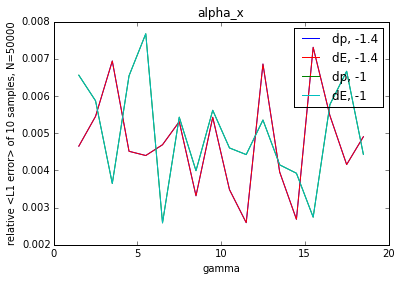

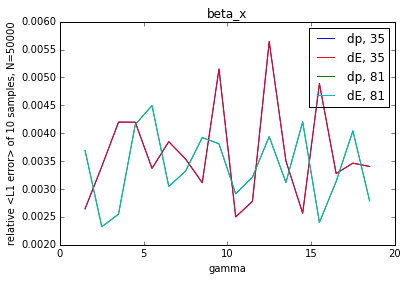

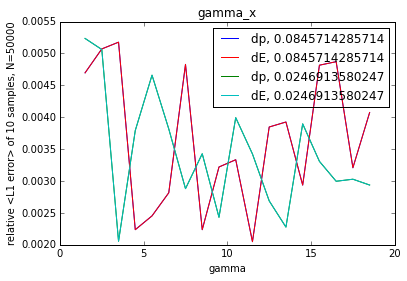

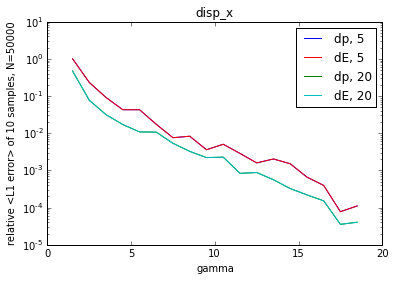

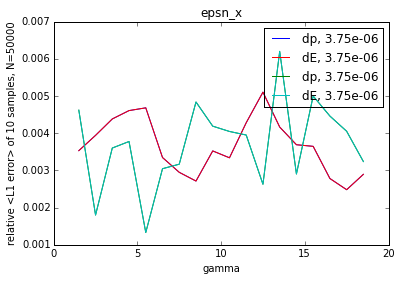

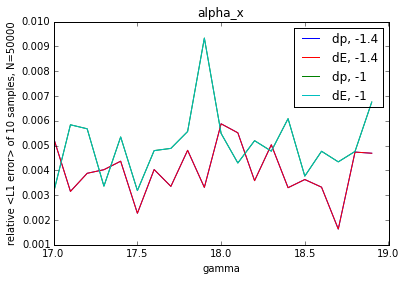

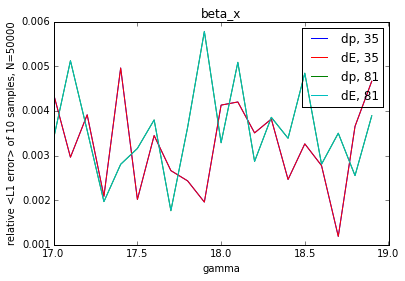

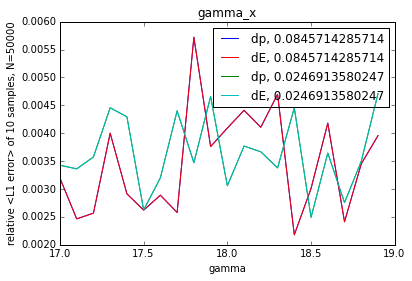

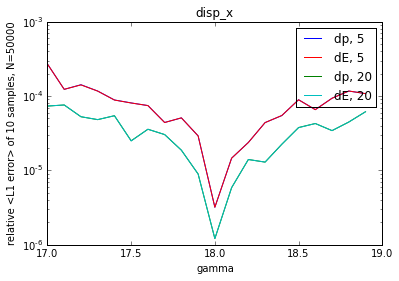

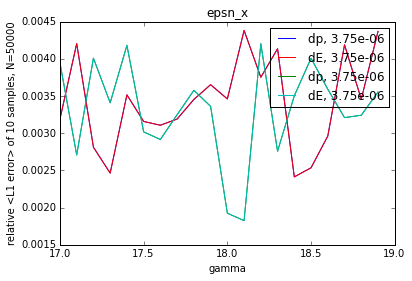

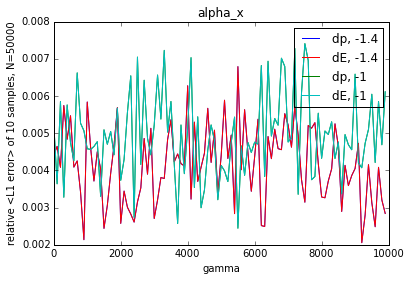

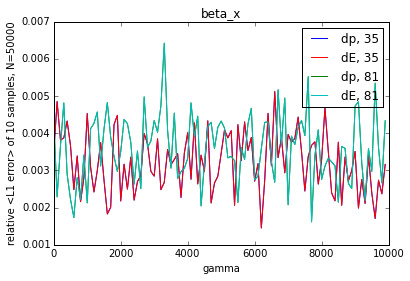

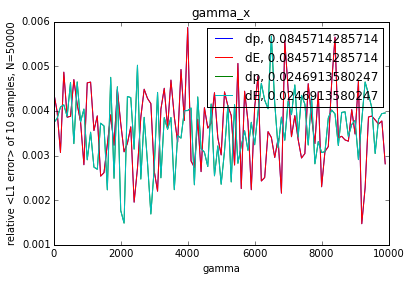

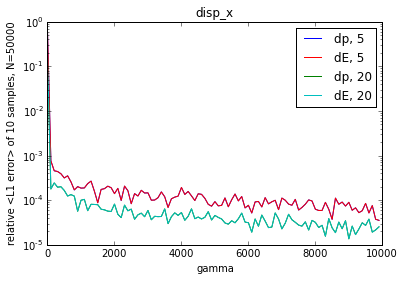

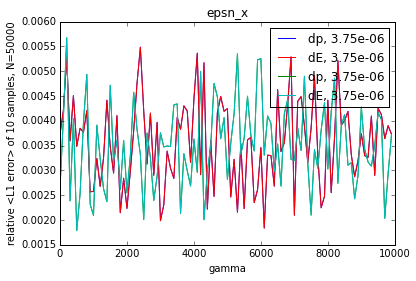

In [6]:
# Run this to test the parameter inference vs gamma
%matplotlib inline
np.random.seed(0)
plot_params_vs_gamma()

In [24]:
def test_transverse_map(n_macroparticles, linear_map, gamma = 3730.27):
    ax = np.array([-1.2, 2., 3.])
    ay = np.array([0.3, 2., 3.])
    bx = np.array([82., 90., 100.])
    by = np.array([45., 30, 80.])
    gx = (ax*ax + 1.) / bx
    gy = (ay*ay + 1.) / by
    dx = np.array([0.5, 5.3, 0.3])
    dy = np.array([0.2, -4.1, 2.09])
    #dx = dy = np.zeros(3)
    segments = np.linspace(0., C, num=4)
    
    # generate a map with the given parameters
    trans_map = TransverseMap(C, segments, ax, bx, dx, ay, by, dy, Q_x, Q_y)
    map_ = [m for m in trans_map]
    
    # generate a bunch matched to the alpha, beta and d of the first segment
    b = generate_bunch(n_macroparticles, ax[0], ay[0], bx[0], by[0], linear_map, dx[0], dy[0], gamma=gamma)
    
    def print_parameters(b, it):
        it = it % 3 #to make sure that after the last segment you access the first segment's parameters
        print('alphax: ' + str(ax[it]) + ' <---> ' + str(b.alpha_Twiss_x()))
        print('alphay: ' + str(ay[it]) + ' <---> ' + str(b.alpha_Twiss_y()))
        print('betax: ' + str(bx[it]) + ' <---> ' + str(b.beta_Twiss_x()))
        print('betay: ' + str(by[it]) + ' <---> ' + str(b.beta_Twiss_y()))
        print('gammax: ' + str(gx[it]) + ' <---> ' + str(b.gamma_Twiss_x()))
        print('gammay: ' + str(gy[it]) + ' <---> ' + str(b.gamma_Twiss_y()))
        print('dispx: ' + str(dx[it]) + ' <---> ' + str(b.dispersion_x()))
        print('dispy: ' + str(dy[it]) + ' <---> ' + str(b.dispersion_y()))
        print('epsnx: ' + str(3.75e-6) + ' <---> ' + str(b.epsn_x_dE()))
        print('epsny: ' + str(3.75e-6) + ' <---> ' + str(b.epsn_y()))
        print('epsnz: ' + 'TODO' + ' <---> ' + str(b.epsn_z()))
        print('\n')
    
    print_parameters(b, 0) # matched to the first segment
    #track and check parameters!
    nturns = 3
    for n in xrange(nturns):
        for it,m in enumerate(map_):
            m.track(b)
            print_parameters(b, it+1)
    #check after the last segment           

            
    

In [7]:
def plot_phase_space(beam, direction):
    plt.figure()
    u = getattr(beam, direction[0])
    up = getattr(beam, direction[1])
    plt.scatter(u, up)
    minimum = min(min(u),min(up))
    maximum =  max(max(u), max(up))
    plt.ylim([minimum, maximum])
    plt.xlim([minimum, maximum])
    plt.xlabel(direction[0])
    plt.ylabel(direction[1])
    plt.show()

In [8]:
# Generate a bunch with the given optics and compare them to the statistically computed parameters
def compute_statistical_beam_optics(alphax, alphay, betax, betay, long_map, dispx, dispy, gamma=3000):
    b = generate_bunch(n_macroparticles, alphax, alphay, betax, betay, long_map, dispx, dispy, gamma)
    gammax = (1. + alphax**2)/betax
    gammay = (1. + alphay**2)/betay
    print('Compare the nominal and the statistically computed quantities from the beam')
    print('nominal: <---> statistical:')
    print('alphax: ' + str(alphax) + ' <---> ' + str(b.alpha_Twiss_x()))
    print('alphax_dE: ' + str(alphax) + ' <---> ' + str(b.alpha_Twiss_x_dE()))
    print('alphay: ' + str(alphay) + ' <---> ' + str(b.alpha_Twiss_y()))
    print('alphay_dE: ' + str(alphay) + ' <---> ' + str(b.alpha_Twiss_y_dE()))
    print('betax: ' + str(betax) + ' <---> ' + str(b.beta_Twiss_x()))
    print('betax_dE: ' + str(betax) + ' <---> ' + str(b.beta_Twiss_x_dE()))
    print('betay: ' + str(betay) + ' <---> ' + str(b.beta_Twiss_y()))
    print('betay_dE: ' + str(betay) + ' <---> ' + str(b.beta_Twiss_y_dE()))
    print('gammax: ' + str(gammax) + ' <---> ' + str(b.gamma_Twiss_x()))
    print('gammax_dE: ' + str(gammax) + ' <---> ' + str(b.gamma_Twiss_x_dE()))
    print('gammay: ' + str(gammay) + ' <---> ' + str(b.gamma_Twiss_y()))
    print('gammay_dE: ' + str(gammay) + ' <---> ' + str(b.gamma_Twiss_y_dE()))
    print('dispx: ' + str(dispx) + ' <---> ' + str(b.dispersion_x()))
    print('dispx_dE: ' + str(dispx) + ' <---> ' + str(b.dispersion_x_dE()))
    print('dispy: ' + str(dispy) + ' <---> ' + str(b.dispersion_y()))
    print('dispy_dE: ' + str(dispy) + ' <---> ' + str(b.dispersion_y_dE()))

    

In [9]:
def plot_histogram(measurements, exact_value, title="Dummy"):
    plt.hist(measurements)
    plt.axvline(measurements.mean(), color='r', linestyle='dashed', linewidth=2)
    plt.axvline(exact_value, color='g', linewidth=2)
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('# observations')
    m = mpatches.Patch(color='red', label='mean')
    ex = mpatches.Patch(color='green', label='input')

    plt.legend(handles=[m, ex])
    plt.show()


In [10]:
def compute_distribution_beam_optics(alphax, alphay, betax, betay, long_map, dispx, dispy, gamma=3000):
    nsamples = 100
    stat_betax = np.zeros(nsamples)
    stat_betay = np.zeros(nsamples)
    stat_alphax = np.zeros(nsamples)
    stat_alphay = np.zeros(nsamples)
    stat_dispx = np.zeros(nsamples)
    stat_dispy = np.zeros(nsamples)
    stat_betax_dE = np.zeros(nsamples)
    stat_betay_dE = np.zeros(nsamples)
    stat_alphax_dE = np.zeros(nsamples)
    stat_alphay_dE = np.zeros(nsamples)
    stat_dispx_dE = np.zeros(nsamples)
    stat_dispy_dE = np.zeros(nsamples)
    for i in xrange(nsamples):
        b = generate_bunch(n_macroparticles, alphax, alphay, betax, betay, long_map, dispx, dispy,gamma)
        stat_betax[i] = b.beta_Twiss_x()
        stat_betay[i] = b.beta_Twiss_y()
        stat_dispx[i] = b.dispersion_x()
        stat_dispy[i] = b.dispersion_y()
        stat_alphax[i] = b.alpha_Twiss_x()
        stat_alphay[i] = b.alpha_Twiss_y()
        stat_betax_dE[i] = b.beta_Twiss_x()
        stat_betay_dE[i] = b.beta_Twiss_y()
        stat_dispx_dE[i] = b.dispersion_x()
        stat_dispy_dE[i] = b.dispersion_y()
        stat_alphax_dE[i] = b.alpha_Twiss_x()
        stat_alphay_dE[i] = b.alpha_Twiss_y()
    plot_histogram(stat_betax, betax, 'beta_x')
    plot_histogram(stat_betax_dE, betax, 'beta_x_dE')
    plot_histogram(stat_betay, betay, 'beta_y')
    plot_histogram(stat_betay_dE, betay, 'beta_y_dE')
    plot_histogram(stat_alphax, alphax, 'alpha_x')
    plot_histogram(stat_alphax_dE, alphax, 'alpha_x_dE')
    plot_histogram(stat_alphay, alphay, 'alpha_y')
    plot_histogram(stat_alphay_dE, alphay, 'alpha_y_dE')
    plot_histogram(stat_dispx, dispx, 'disp_x')
    plot_histogram(stat_dispx_dE, dispx, 'disp_x_dE')
    plot_histogram(stat_dispy, dispy, 'disp_y')
    plot_histogram(stat_dispy_dE, dispy, 'disp_y_dE')

    plt.show()


In [11]:
# Basic simulation parameters
n_turns = 10
n_segments = 2
n_macroparticles = 100000

Q_x = 20.13
Q_y = 20.18
Q_s = 0.017

C = 6911.
R = C / (2.*np.pi)

alpha_0 = [0.00308]
long_map = LinearMap(alpha_0, C, Q_s)

mass: 1.672621777e-27
c**2: 8.98755178737e+16
E0: 5.60763090079e-07
<dE2>: 4.18525009924e-19
<dp2>: 1.33095274808e-06
Compare the nominal and the statistically computed quantities from the beam
nominal: <---> statistical:
alphax: 0.5 <---> 0.498701955787
alphax_dE: 0.5 <---> 0.498701955787
alphay: -1.7 <---> -1.69750013661
alphay_dE: -1.7 <---> -1.69750013666
betax: 90 <---> 90.5206511521
betax_dE: 90 <---> 90.5206511521
betay: 40 <---> 40.0622285158
betay_dE: 40 <---> 40.0622285164
gammax: 0.0138888888889 <---> 0.0137946824676
gammax_dE: 0.0138888888889 <---> 0.013794682482
gammay: 0.09725 <---> 0.0968869331256
gammay_dE: 0.09725 <---> 0.0968869395863
dispx: 4.3 <---> 2.70936363602
dispx_dE: 4.3 <---> 2.75251458557
dispy: -3.0 <---> -3.00108834631
dispy_dE: -3.0 <---> -3.00108768382


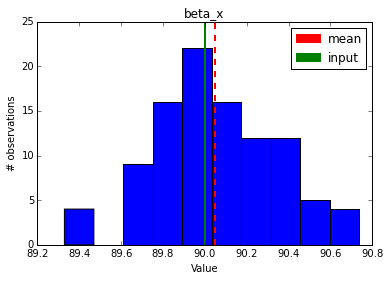

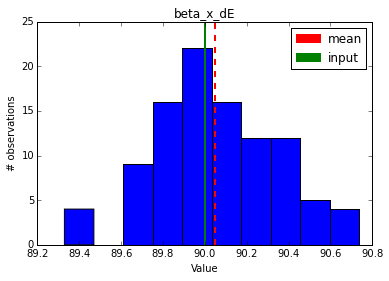

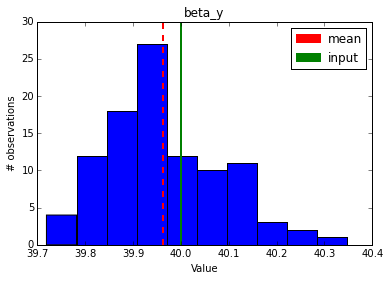

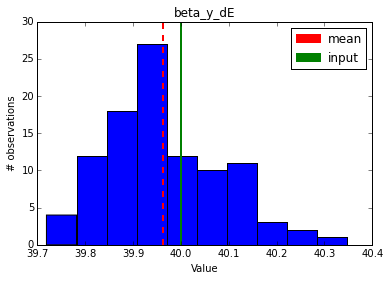

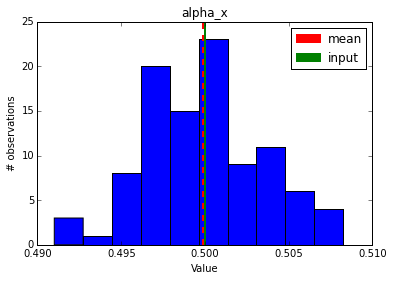

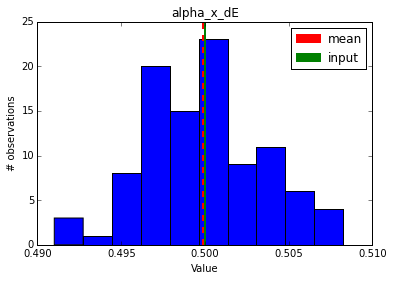

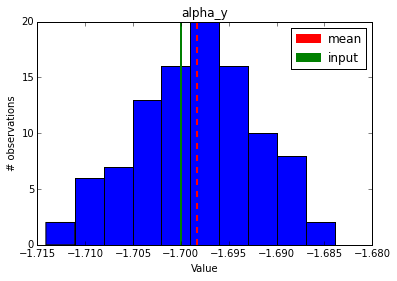

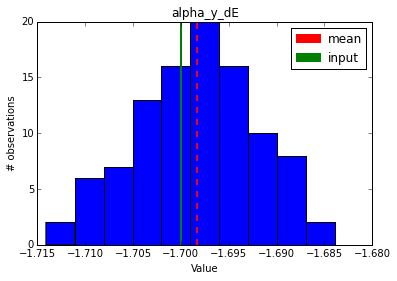

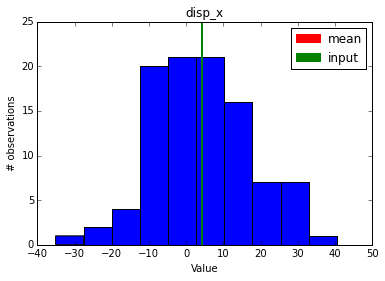

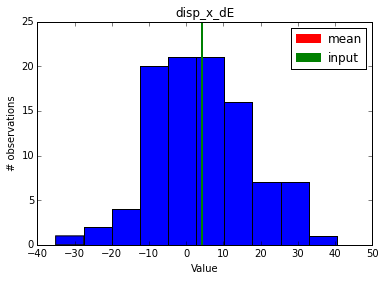

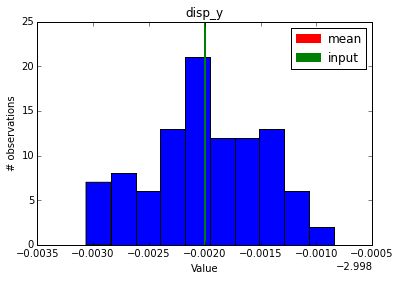

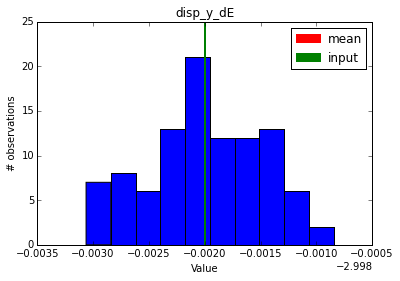

In [15]:
%matplotlib inline
alphax = 0.5
alphay = -1.7
betax = 90
betay = 40
dispx = 4.3
dispy = -3.
gamma = 1000
beam2 = generate_bunch(n_macroparticles, alphax, alphay, betax, betay, long_map, dispx, dispy, gamma)
print('mass: ' + str(beam2.mass))
print('c**2: ' + str(c**2))
print('E0: ' + str(beam2.gamma*beam2.mass*c*c))
print('<dE2>: ' + str(np.mean(beam2._dE()**2)))
print('<dp2>: ' + str(np.mean(beam2.dp**2)))
compute_statistical_beam_optics(alphax, alphay, betax, betay, long_map, dispx, dispy, gamma)

compute_distribution_beam_optics(alphax, alphay, betax, betay, long_map, dispx, dispy, gamma)


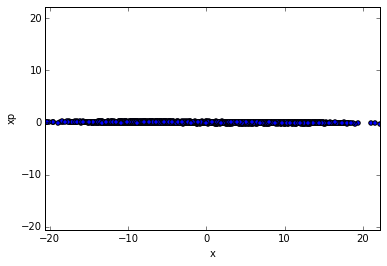

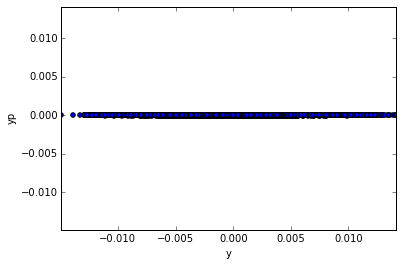

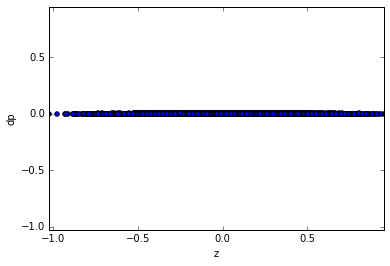

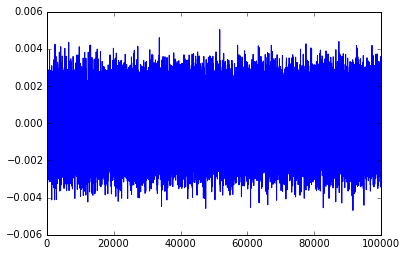

In [16]:
%matplotlib inline
plot_phase_space(beam2, ['x', 'xp'])
plot_phase_space(beam2, ['y', 'yp'])
plot_phase_space(beam2, ['z', 'dp'])
plt.plot(beam2.dp)
plt.show()

In [25]:
test_transverse_map(100000, long_map, 4000) 


*** PyHEADTAIL WARNING! Non-zero dispersion; ensure the beam has been "blown-up" accordingly upon creation!
alphax: -1.2 <---> -1.19555844998
alphay: 0.3 <---> 0.301676454236
betax: 82.0 <---> 81.8708758321
betay: 45.0 <---> 45.114777312
gammax: 0.029756097561 <---> 0.0296730674995
gammay: 0.0242222222222 <---> 0.0241829561827
dispx: 0.5 <---> 0.499678117779
dispy: 0.2 <---> 0.200209358796
epsnx: 3.75e-06 <---> 3.7382873056e-06
epsny: 3.75e-06 <---> 3.75091666387e-06
epsnz: TODO <---> 41.5176192391


alphax: 2.0 <---> 1.99732085967
alphay: 2.0 <---> 1.99446782827
betax: 90.0 <---> 90.0143059891
betay: 30.0 <---> 29.9190608663
gammax: 0.0555555555556 <---> 0.0554277521414
gammay: 0.166666666667 <---> 0.166378950219
dispx: 5.3 <---> 5.29992611801
dispy: -4.1 <---> -4.10018348196
epsnx: 3.75e-06 <---> 3.73828730561e-06
epsny: 3.75e-06 <---> 3.75091666349e-06
epsnz: TODO <---> 41.5176192391


alphax: 3.0 <---> 3.00663973175
alphay: 3.0 <---> 3.00723762718
betax: 100.0 <---> 100.131299592
